# Date of first/last ice, season length

In [1]:
import numpy as np 
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings; warnings.simplefilter('ignore')
import pickle

from functions import load_ice, trend, find_trends, plot_cartopy, decomp

# input data directory

path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# 2021
path2021 = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc-for-May-2021-06-02')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)
fname2021 = path2021 / '{}.nc'.format(region) # 2021

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)
ds2021 = xr.open_dataset(fname2021)

juld = ds.juld
juld2021 = ds2021.juld
# Combine data structures
juld = xr.concat([juld, juld2021], "juld")

# subset `xarray.Dataset` by index
# ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))
# ds2021 = ds2021.isel(x=slice(1700, None), y=slice(600, 1450))

# Labrador shelf only
ds = ds.isel(x=slice(1800, 2500), y=slice(800, 1450))
ds2021 = ds2021.isel(x=slice(1800, 2500), y=slice(800, 1450))



# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']
N_CTold = ds['N_CT']
N_CT2021 = ds2021['N_CT']


E_SAold = ds['E_SA']
E_SA2021 = ds2021['E_SA']

E_CT = xr.concat([N_CTold, N_CT2021], dim="juld")
E_SA = xr.concat([E_SAold, E_SA2021], dim="juld")

Function for getting the first and last date of ice for an individual grid cell

In [2]:
def ice_date(lon0, lat0, first_or_last):
    '''lon0, lat0 is the lon, lat pair of desired grid cell'''
    # Pick for one location 
    d = np.sqrt((lon.data-lon0)**2 + (lat.data-lat0)**2) 
    # index for lon and lat of Hopedale
    loc = np.unravel_index(np.argmin(d, axis=None), d.shape)
    # Loop over all years until we find the first instance of ice
    cnt=0
    first_ice_arr = np.zeros(len(years_unique))
    # E_CT_yearly = E_CT[:,473,477].groupby("juld.year")
    E_CT_yearly = E_CT[:,loc[0], loc[1]].resample(juld="AS-SEP")
    for yr in list(E_CT_yearly):
        # Jan 1 of given year
        date_init = datetime.date(yr[1].juld.dt.year[0], 1, 1)
        # First index of given year where there is ice. Second index val is 0 for first ice, -1 for last ice
        if np.sum(~np.isnan(yr[1])) > 0:
            if first_or_last == 'first':
                # Index of first occurence
                first_ice = np.where(~np.isnan(yr[1]))[0][0]
            elif first_or_last == 'last':
                first_ice = np.where(~np.isnan(yr[1]))[0][-1]
        else: 
            print('Empty array: ' + yr)

        first_ice_yr = yr[1].juld.dt.year[first_ice]
        first_ice_month = yr[1].juld.dt.month[first_ice]
        first_ice_day = yr[1].juld.dt.day[first_ice]
        first_ice_date = datetime.date(first_ice_yr, first_ice_month, first_ice_day)
        # Save number of days since sept 1
        dt = first_ice_date - date_init
        first_ice_arr[cnt] = dt.days
        cnt+=1
        
        
    return first_ice_arr

In [3]:
# Replace eggcode values for concentration with real values
# A = xr.where(E_CT>9, E_CT, E_CT/10)
# B = xr.where(E_CT==10, 0.95, A)
# CT = xr.where(E_CT==11, 1, B)

# Replace eggcode values for thickness with real values
A = xr.where(E_SA==1, 0.05, E_SA)
B = xr.where(E_SA==4, 0.125, A)
C = xr.where(E_SA==5, 0.225, B)
D = xr.where(E_SA==7, 0.50, C)
E = xr.where(E_SA==10, 0.95, D)
F = xr.where(E_SA==11, 1.60, E)
G = xr.where(E_SA==12, 2.50, F)
HA = xr.where(E_SA>13, np.nan, G)

In [4]:
years = juld.dt.year
months = juld.dt.month

years_unique = np.unique(years)
eggcode = E_CT
inds_clean = np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])
years_unique_clean = years_unique[inds_clean]

## Date of first/last ice

Plot the date of first/last ice for different communities

In [ ]:
# Hopedale
lon_HD = -60.1
lat_HD = 55.5

# Nain
lon_nain = -60.7
lat_nain = 56.7

# Makkovik
lon_makk = -59.0
lat_makk = 55.2

lon_commun = [lon_HD, lon_nain, lon_makk]
lat_commun = [lat_HD, lat_nain, lat_makk]

# Plot location of grid cell
fig = plt.figure(figsize=(14,6), facecolor='white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax = fig.add_subplot(gs[0], projection=rot)
plot_cartopy(ax,lon,lat)
colour = ['r','g','b']

for i in range(0,3):
    c=colour[i]
    lon0 = lon_commun[i]
    lat0 = lat_commun[i]
    d = np.sqrt((lon.data-lon0)**2 + (lat.data-lat0)**2) 
    # index for lon and lat of Hopedale
    loc = np.unravel_index(np.argmin(d, axis=None), d.shape)
    plt.plot(lon[loc], lat[loc], colour[i] + '*', markersize=14, markeredgecolor = 'k',transform=ccrs.PlateCarree(), zorder=4)
    
ax = fig.add_subplot(gs[1])

for i in range(0,3):
    c=colour[i]
    first_ice_arr = ice_date(lon_commun[i], lat_commun[i], 'first')
    last_ice_arr = ice_date(lon_commun[i], lat_commun[i], 'last')
    # Add trendline
    s,b = np.polyfit(years_unique_clean,first_ice_arr[inds_clean],1)
    plt.plot(years_unique_clean, first_ice_arr[inds_clean], c + 'o-')
    plt.plot(years_unique_clean, s*years_unique_clean + b, c + '--', label='Slope = %.2f d/y' %s )
    
plt.xticks(years_unique_clean,rotation='vertical', fontsize=13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks([334, 365, 396]) # first ice
ax.set_yticklabels(['Dec','Jan','Feb'])
# plt.yticks([485, 516,546]) # last ice 
# ax.set_yticklabels(['May','Jun','Jul'])
plt.ylabel('Month of year', fontsize=15)

# Add secondary axis
secax = ax.secondary_yaxis('left')
secax.set_ylabel('Days since Jan 1', fontsize=15)
secax.tick_params(axis='both', which='major', labelsize=13)

plt.yticks(fontsize=13)
plt.title('Date of first ice', fontsize=15)
plt.legend()
# plt.savefig('/home/mwang/CIS-project/figures/Jun22_first_ice.png', dpi=200)

## Date of first/last ice for whole region

In [5]:
tic=time.time()
cnt=0
l = len(years_unique)
m = np.shape(E_CT)[1]
n = np.shape(E_CT)[2]
last_ice = np.zeros((l,m,n))
# first_ice_arr = np.zeros((len(years_unique),m,n))
# E_CT_yearly = E_CT[:,473,477].groupby("juld.year")
# Use resample function to start ears in Sept
E_CT_yearly = E_CT.resample(juld="AS-SEP")
for yr in list(E_CT_yearly):
    # First index of given year where there is ice. Second index val is 0 for first ice, -1 for last ice
    for i in range(m):
        for j in range(n):
            if np.sum(~np.isnan(yr[1][:,i,j])) > 0:
                # Index of first (0) or last (-1) occurence
                last_ice[cnt,i,j] = np.where(~np.isnan(yr[1][:,i,j]))[0][-1]
            else: 
                # If no ice occurence (ie. open water), save as nan
                last_ice[cnt,i,j] = np.nan
    cnt+=1
#     print(yr[0])
    
toc = time.time()
print(toc-tic)   


10301.783232212067


In [6]:
# get dates/days since jan 1 from indices
last_ice_arr = np.zeros((len(years_unique),m,n))
cnt=0
for yr in list(E_CT_yearly):
    # Jan 1 of given year
    date_init = datetime.date(yr[1].juld.dt.year[0], 1, 1)
    for i in range(m):
        for j in range(n):
            if np.isnan(last_ice[cnt,i,j])==False:
                last_ice_yr = yr[1].juld.dt.year[int(last_ice[cnt,i,j])]
                last_ice_month = yr[1].juld.dt.month[int(last_ice[cnt,i,j])]
                last_ice_day = yr[1].juld.dt.day[int(last_ice[cnt,i,j])] 
                last_ice_date = datetime.date(last_ice_yr, last_ice_month, last_ice_day)
                # Save number of days since Jan 1
                dt = last_ice_date - date_init
                last_ice_arr[cnt,i,j] = dt.days
            else: 
                last_ice_arr[cnt,i,j] = np.nan

    cnt+=1

Try splitting into 5 or 10 year groups and plot the mean of that time period on a map. 

# Trends in first/last ice date

In [9]:
# # Calculate trends

l = len(years_unique)
m = np.shape(E_CT)[1]
n = np.shape(E_CT)[2]

ytrend = np.zeros((m,n))
dtrend_95 = np.zeros((m,n))
slope_last = np.zeros((m,n))
intercept = np.zeros((m,n))
# first_ice_arr_clean = first_ice_arr[inds_clean]

# Calculate trends along time axis
for i in range(m):
    for j in range(n):
#         mean, tr, dt95 = trend(years_unique, first_ice_arr[:,i,j])
#         ytrend[i,j] = tr
#         dtrend_95[i,j] = dt95
        s,b = np.polyfit(years_unique,last_ice_arr[:,i,j],1)
        slope_last[i,j] = s
#         intercept[i,j] = b

In [11]:
np.nanmean(slope_last)

2.491145711321298

In [33]:
def hatch(array,dtrend_95):
    
    '''
    Hatching array for monthly or seasonal trends given an array and dtrend_95. Called in gmap function for plotting. 
    '''
   
    hatched = np.zeros(np.shape(array))
    sign = np.sign(array)
#     hatched = np.zeros(np.shape(ytrend_monthly[i,:,:]))
    for (x,y), value in np.ndenumerate(sign):
        if np.sign(array[x,y] + dtrend_95[x,y]) != value or np.sign(array[x,y] - dtrend_95[x,y]) != value:
            # Create array for hatching. Ones represent non-significant values
            hatched[x,y]=1
    # Make nans insignificant
    hatched[np.isnan(hatched)==True]=1
    
    return hatched

# Plot trends

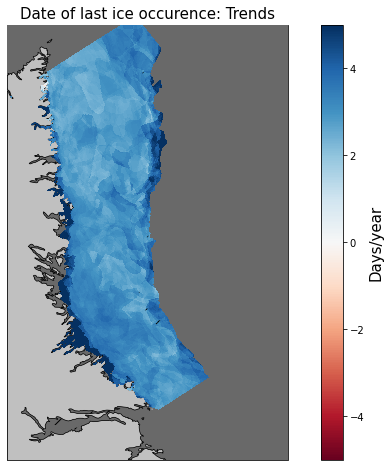

In [248]:
fig = plt.figure(figsize=(12,8), facecolor='white')
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
im = plt.pcolormesh(lon,lat,slope_last,vmin=-5,vmax=5,cmap='RdBu',transform=ccrs.PlateCarree(),zorder=4)
# Hatch significant values
plt.contourf(lon,lat,hatched_last,levels=1, hatches=['/', ''],  alpha=0.,transform=ccrs.PlateCarree(),zorder=5)
cb = plt.colorbar(im)
cb.set_label(label='Days/year',fontsize=15)
plt.title('Date of last ice occurence: Trends',fontsize=15)
plt.savefig('/home/mwang/CIS-project/figures/Jul14_last_ice_trends_allyrs.png', dpi=200)

# Group per decade and view average start/end date

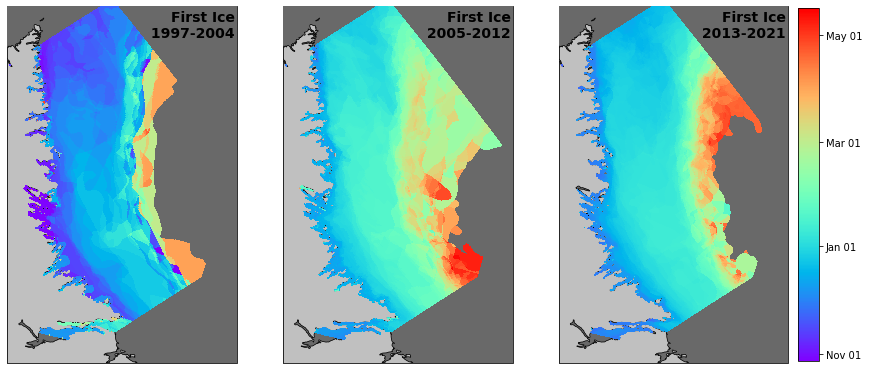

In [250]:
# Freeze onset

fig = plt.figure(figsize=(14,11), facecolor='white')
vmin = 300
vmax = 500
cmap = 'rainbow'

ax = fig.add_subplot(1,3,1, projection=rot)
plot_cartopy(ax,lon,lat)
dec1 = np.nanmean(first_ice_arr[:8], axis=0)
cax = plt.pcolormesh(lon,lat,dec1,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4, cmap=cmap)
ax.text(0.99,0.99, 'First Ice\n 1997-2004', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)

# plt.title('1997-2007')

ax = fig.add_subplot(1,3,2, projection=rot)
plot_cartopy(ax,lon,lat)
dec2 = np.nanmean(first_ice_arr[8:16], axis=0)
cax = plt.pcolormesh(lon,lat,dec2,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4,cmap=cmap)
ax.text(0.99,0.99, 'First Ice\n 2005-2012', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)

ax = fig.add_subplot(1,3,3, projection=rot)
plot_cartopy(ax,lon,lat)
dec3 = np.nanmean(first_ice_arr[16:], axis=0)
cax = plt.pcolormesh(lon,lat,dec3,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4,cmap=cmap)
ax.text(0.99,0.99, 'First Ice\n 2013-2021', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)

cb_ax = fig.add_axes([0.91, 0.28, 0.02, 0.445]) # left, bottom, width, height
# Start of the months
mon_intervals = [304,365,424,485]
cbar = fig.colorbar(cax, cax=cb_ax, ticks=mon_intervals)
date_labels = [datetime.date(1997,1,1) + datetime.timedelta(days=mon_intervals[i]) for i in range(len(mon_intervals))]
cbar_ticks = [date_labels[i].strftime("%b %d") for i in range(len(date_labels))]
cbar.ax.set_yticklabels(cbar_ticks)  # vertically oriented colorbar

# plt.savefig('/home/mwang/CIS-project/figures/Jul14_first_ice_groups.png', dpi=200)

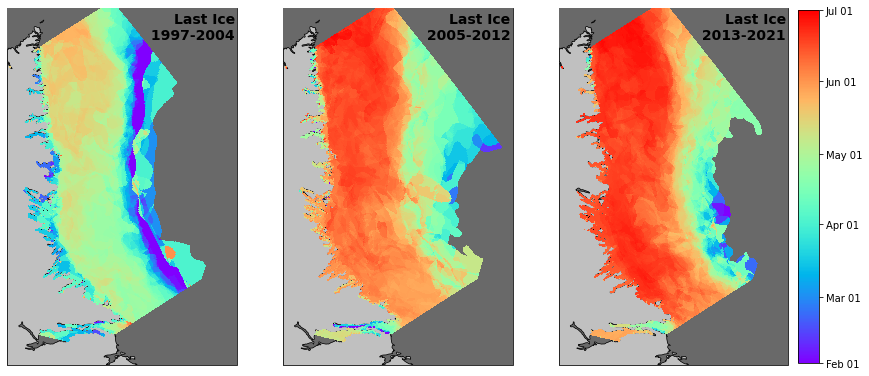

In [251]:
# Melt onset

fig = plt.figure(figsize=(14,11), facecolor='white')
vmin = 396
vmax = 546
cmap = 'rainbow'

ax = fig.add_subplot(1,3,1, projection=rot)
plot_cartopy(ax,lon,lat)
dec1 = np.nanmean(last_ice_arr[:8], axis=0)
cax = plt.pcolormesh(lon,lat,dec1,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4, cmap=cmap)
ax.text(0.99,0.99, 'Last Ice\n 1997-2004', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)

# plt.title('1997-2007')

ax = fig.add_subplot(1,3,2, projection=rot)
plot_cartopy(ax,lon,lat)
dec2 = np.nanmean(last_ice_arr[8:16], axis=0)
cax = plt.pcolormesh(lon,lat,dec2,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4,cmap=cmap)
ax.text(0.99,0.99, 'Last Ice\n 2005-2012', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)

ax = fig.add_subplot(1,3,3, projection=rot)
plot_cartopy(ax,lon,lat)
dec3 = np.nanmean(last_ice_arr[16:], axis=0)
cax = plt.pcolormesh(lon,lat,dec3,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4,cmap=cmap)
ax.text(0.99,0.99, 'Last Ice\n 2013-2021', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)

# Colorbar ticks and properties
cb_ax = fig.add_axes([0.91, 0.28, 0.02, 0.445]) # left, bottom, width, height
# Start of the months
mon_intervals = [396,424,455,485,516,546]
cbar = fig.colorbar(cax, cax=cb_ax, ticks=mon_intervals)
# Change labels to dates
date_labels = [datetime.date(1997,1,1) + datetime.timedelta(days=mon_intervals[i]) for i in range(len(mon_intervals))]
cbar_ticks = [date_labels[i].strftime("%b %d") for i in range(len(date_labels))]
cbar.ax.set_yticklabels(cbar_ticks)  # vertically oriented colorbar

plt.savefig('/home/mwang/CIS-project/figures/Jul14_last_ice_groups.png', dpi=200)

## Pickle

In [7]:
with open('last_ice_arr.pickle', 'wb') as f:
    pickle.dump(last_ice_arr, f)



# Load bathymetry data

Modify file extract_bathy.py from /home/oliver/data/bathymetry/GEBCO to expand domain for my region. 

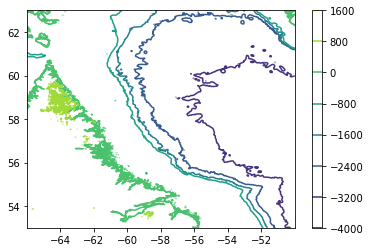

In [329]:
'''
    Generate subset of GEBCO bathy data
'''

import numpy as np
from netCDF4 import Dataset

lon1 = -66
lon2 = -50
lat1 = 53
lat2 = 63


# Load in Bathymetry
fileobj = Dataset('/home/oliver/data/bathymetry/GEBCO/GEBCO_2014_2D.nc', 'r')
lon_bathy = fileobj['lon'][:] #.data
lat_bathy = fileobj['lat'][:] #.data
j1 = np.where(lat_bathy >= lat1)[0][0]
j2 = np.where(lat_bathy >= lat2)[0][0]
i1 = np.where(lon_bathy >= lon1)[0][0]
i2 = np.where(lon_bathy >= lon2)[0][0]
bathy = fileobj.variables['elevation'][j1:j2,i1:i2] #.data
lon_bathy = lon_bathy[i1:i2]
lat_bathy = lat_bathy[j1:j2]
fileobj.close()

# Save subset
np.savez('GEBCO_2014_2D_MW.Labrador.npz', lon_bathy=lon_bathy, lat_bathy=lat_bathy, bathy=bathy)



file = 'GEBCO_2014_2D.Labrador.npz'
data = np.load(file)
bathy = data['bathy']
lon_bathy = data['lon_bathy']
lat_bathy = data['lat_bathy']

plt.contour(lon_bathy,lat_bathy,bathy)
plt.colorbar()

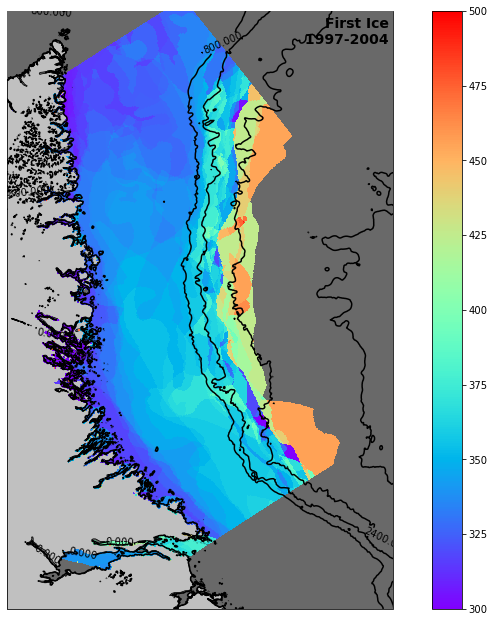

In [333]:
fig = plt.figure(figsize=(14,11), facecolor='white')
vmin = 300
vmax = 500
cmap = 'rainbow'

ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
dec1 = np.nanmean(first_ice_arr[:8], axis=0)
cax = plt.pcolormesh(lon,lat,dec1,vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree(),zorder=4, cmap=cmap)
ax.text(0.99,0.99, 'First Ice\n 1997-2004', weight='bold', fontsize=14,horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,zorder=4)
CS = ax.contour(lon_bathy,lat_bathy,-bathy,colors='k',transform=ccrs.PlateCarree(),zorder=5)
ax.clabel(CS, inline=True, fontsize=10)
cba = plt.colorbar(cax)
